# Formal Proof and Empirical Simulation of Nearest Advocate beeing a metric



## Problem formulation

Let $\mathcal{T}_n = \{t_i: \ t_i \in \mathbb{R} \land t_i-t_{i-1}>0 \ \forall i = 1,2,..., n\}$ an event time series of true timestamps, i.e., sets with strict increasing order and 
$\mathcal{S}_{m} = \{s_j: \ s_j \in \mathbb{R} \land s_j-s_{j-1}>0 \ \forall j = 1,2,...,m \}$ the measurement of $T_n$
with a time delay $\phi_s$ between the event time series such that:

$$\forall j \leq m: \ \exists i \leq n: \ s_j = t_i + \phi_s + \varepsilon_{ji}$$
   
As we can expect the distribution of errors to be centered around zero $\mathbb{E}[\varepsilon]=0$, the time delay can be estimated if $m=n$ and $i=j$ using, e.g., the MAE:

$$\hat{\phi_s} = \argmin_{\phi \in \mathbb{R}} \sum_{i=1}^n \vert s_i - t_i - \phi \vert$$

For the case of undetected or not matched events in $\mathcal{S}$, this estimate is no longer valid and the process of time delay estimation must be weakened to:

We assume $m \leq n$ and we know the mapping between matching events as injective and strictly monotonically increasing function $f: \ j \mapsto i$, then $\phi$ can be estimated by:

$$\hat{\phi_s} = \argmin_{\phi \in \mathbb{R}} \sum_{j=1}^m \vert s_j - t_{f(i)} - \phi \vert$$

However, in practice, the function $f$ is often unknown, complicating the problem of time delay estimation. 
Therefore, we propose the algorithm **Nearest Advocate** so solve this problem, which does not depend on $f$.



In [2]:
# Import packages used here
import os
# Set the path such that the package can be found locally
os.chdir("/home/jovyan/work/Synchronization/git_nearest_advocate/")

import time
import numpy as np
np.random.seed(1)  # set seed
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import src.nearest_advocate_numba as nearest_advocate


SIM_COUNT = int(1e4)

In [1]:
from typing import Optional

import numpy as np

try:
    import numba
except ModuleNotFoundError:
    print("\nError: The 'numba' module is not installed.")
    print("You can install it using the following command:")
    print("pip install numba\n")


@numba.njit(parallel=False)
def nearest_advocate_single(arr_ref: 'np.ndarray[np.float32]', arr_sig: 'np.ndarray[np.float32]',
                            dist_max: float) -> float:
    '''Calculates the synchronicity of two arrays of timestamps in terms of the mean of all minimal distances between each event in arr_sig and it's nearest advocate in arr_ref.
    arr_ref (np.array): Reference array or timestamps assumed to be correct
    arr_sig (np.array): Signal array of  timestamps, assumed to be shifted by an unknown constant time-delta
    dist_max (float): Maximal accepted distances, should be 1/4 of the median gap of arr_ref
    '''
    # Assert input properties
    assert dist_max > 0.0          # maximal distance must be greater than 0.0

    # store the lengths of the arrays
    l_arr_ref = len(arr_ref)
    l_arr_sig = len(arr_sig)
    assert l_arr_ref >= 2 and l_arr_sig >= 2

    ref_idx = 0              # index for arr_ref
    sig_idx = 0              # index for arr_sig
    cum_distance = 0.0       # cumulative distances between advocate events

    # Case 1: cut leading reference timestamps without finding advocates
    while ref_idx + 1 < l_arr_ref and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
        ref_idx += 1

    # Case 2 and Case 3: At least one signal ts is not matched with the final reference ts
    if ref_idx + 1 < l_arr_ref:
        assert arr_sig[sig_idx] < arr_ref[ref_idx+1]

        # Case 2: match leading signal timestamps with nearest advocates
        while sig_idx < l_arr_sig and arr_sig[sig_idx] < arr_ref[ref_idx]:
            # Loop invariant: arr_sig[sig_idx] < arr_ref[ref_idx]
            cum_distance += min(arr_ref[ref_idx]-arr_sig[sig_idx], dist_max)
            sig_idx += 1
        # if arr_sig ends before arr_ref starts, other cases are skipped as sig_idx = l_arr_sig

        # Case 3: Regular case of
        while sig_idx < l_arr_sig and ref_idx < l_arr_ref - 1:
            # forward arr_ref and then arr_sig until the invariant holds
            while ref_idx < l_arr_ref - 1 and arr_ref[ref_idx+1] <= arr_sig[sig_idx]:
                ref_idx += 1
            if ref_idx < l_arr_ref - 1:
                # Invariant: arr_ref[ref_idx] <= arr_sig[sig_idx] < arr_ref[ref_idx+1]
                assert arr_ref[ref_idx] <= arr_sig[sig_idx] + 1e-12
                assert arr_sig[sig_idx] < arr_ref[ref_idx+1] + 1e-12
                cum_distance += min(arr_sig[sig_idx]-arr_ref[ref_idx], arr_ref[ref_idx+1]-arr_sig[sig_idx], dist_max)
                sig_idx += 1

    # Case 4: match trailing signal timestamps with last reference ts
    while sig_idx < l_arr_sig:
        # Invariant: arr_ref[-1] <= arr_sig[sig_idx]
        assert arr_ref[-1] <= arr_sig[sig_idx] + 1e-12
        cum_distance += min(arr_sig[sig_idx]-arr_ref[-1], dist_max)
        sig_idx += 1

    # return mean cumulative distance between found advocate events
    assert cum_distance / l_arr_sig <= dist_max + 1e-12
    return cum_distance / l_arr_sig

def nearest_advocate_sym(arr_ref, arr_sig, dist_max=1.0):
    d_l = nearest_advocate_single(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=dist_max)
    d_r = nearest_advocate_single(arr_ref=arr_sig, arr_sig=arr_ref, dist_max=dist_max)

    # Merge the partial results
    d = 1/2 * (d_l + d_r)
    return d

In [3]:
# Checks of the algorithm easy to calculate

arr_ref = np.array([5, 10, 11, 14, 19])
arr_sig = np.array([1, 3, 7, 13, 16, 17, 18, 21, 23])
assert nearest_advocate_single(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=10.0)*len(arr_sig) == 20
assert nearest_advocate_single(arr_ref=arr_sig, arr_sig=arr_ref, dist_max=10.0)*len(arr_ref) == 9
# check reverse
assert nearest_advocate_single(arr_ref=-arr_ref[::-1], arr_sig=-arr_sig[::-1], dist_max=10.0)*len(arr_sig) == 20
assert nearest_advocate_single(arr_ref=-arr_sig[::-1], arr_sig=-arr_ref[::-1], dist_max=10.0)*len(arr_ref) == 9

arr_ref = np.array([5, 10, 11, 14, 19])
arr_sig = np.array([1, 3, 7, 13, 16, 17, 18, 21, 23])
assert nearest_advocate_single(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=2.0)*len(arr_sig) == 16
assert nearest_advocate_single(arr_ref=arr_sig, arr_sig=arr_ref, dist_max=2.0)*len(arr_ref) == 8
# check reverse
assert nearest_advocate_single(arr_ref=-arr_ref[::-1], arr_sig=-arr_sig[::-1], dist_max=2.0)*len(arr_sig) == 16
assert nearest_advocate_single(arr_ref=-arr_sig[::-1], arr_sig=-arr_ref[::-1], dist_max=2.0)*len(arr_ref) == 8

## Definition of a Metric Space:

Formally, a metric space is an ordered pair \((M, D)\) where \(M\) is a set and \(D\) is a metric on \(M\), i.e., a function

$$ D: M \times M \to \mathbb{R} $$

satisfying the following axioms for all points \(x, y, z \in M\):

1. **Positive-definite:**
    The distance from a point to any other point is non-negative:
    \( D(x, y) \geq 0 \) and the distance is only zero iff the two points are equal:
   $$D(x, y) = 0 \iff  x = y$$

2. **Symmetry:** The distance from \(x\) to \(y\) is always the same as the distance from \(y\) to \(x\):
   $$ D(x, y) = D(y, x) $$

3. **Triangle Inequality:** The distance between two points is always less than or equal to the sum of the distances of those points to a third point:
   $$ D(x, z) \leq D(x, y) + D(y, z) $$


### Application

Here we construct a metric space as $(M, D_{\text{NAd}})$ where $M = \{\mathcal{T} \subset \mathbb{R}: \ \mathcal{T}=\{t_i: \ t_i \in \mathbb{R} \land \ t_i-t_{i-1} > 0 \ \forall i = 1, 2, \ldots, n\}\} \subset \mathcal{P}(\mathbb{R})$ and $\mathcal{X},\mathcal{Y},\mathcal{Z} \in M$ are sets with strict increasing order for their elements in $\mathbb{R}$. 

The function $D_{\text{NAd}}: \ M\times M \to \mathbb{R}$ is the Nearest Advocate algorithm as defined in the code and illustrated in the pseudocode, with the single parameter $d_{\max} > 0$.

### Symmetric Nearest Advocate

Similar to the Kullback-Leibler Divergence, the Nearest Advocate requires a symmetric version that is constructed by applying the basic function to its arguments in both directions.

$$D_{\text{NAd-symmetric}}(\mathcal{X},\mathcal{Y}) \coloneqq \frac{1}{2} \left( D_{\text{NAd}}(\mathcal{X},\mathcal{Y}) + D_{\text{NAd}}(\mathcal{Y},\mathcal{X}) \right)$$

To shorten the notation, we denote $D_{\text{NAd-symmetric}}$ as $D$ and express the single parameter $d_{\max}$ in subscript as $D_{d_{\max}}$.

## Theorem 1:

The Symmetric Nearest Advocate $D$ over $M_{\Delta t_{\min}} = \{\mathcal{T} \subset \mathbb{R}: \ \mathcal{T}=\{t_i: \ t_i \in \mathbb{R} \land \ t_i-t_{i-1} \geq \Delta t_{\min} \ \forall i = 1, 2, \ldots, n\}\}$ is a metric space for all $\Delta t_{\min} > 0$.



## Proof Overview

1. **Contradiction of Positive-Definiteness in $(M, D_{\text{NAd}})$:** We explore a scenario that contradicts the assumption that $(M, D_{\text{NAd}})$ is positive-definite.
2. **Proof of Positive-Definiteness in $(M, D)$:** We demonstrate that the metric space $(M, D)$ satisfies the positive-definiteness property.
3. **Contradiction of Symmetry in $(M, D_{\text{NAd}})$:** We present a case that contradicts the symmetry property in $(M, D_{\text{NAd}})$
4. **Proof of Symmetry in $(M, D)$:** We prove that the metric space $(M, D)$adheres to the symmetry property.

5. **Contradiction of Triangle Inequality in $M, D_{\text{NAd}})$** We identify a contradiction to the triangle inequality in the context of $M, D_{\text{NAd}})$.
6. **Proof of Triangle Inequality in $(M', D)$:** We establish that the metric space $(M', D)$ satisfies the triangle inequality.

Therefore, $(M', D)$ is confirmed as a metric space.


### Ad 1) Contradiction of $(M, D_{\text{NAd}})$ being positive-definite

Let $\mathcal{X}=\{1,2,3\}$, $\mathcal{Y}=\{1,3\}$, then for any $d_{\max}>0$

$$D_{\text{NAd}}(\mathcal{X}, \mathcal{Y}) = \frac{1}{2}(\min(\vert 1-1 \vert, d_{\max}) + \min(\vert 3-3 \vert, d_{\max})) = 0$$

Remember that each element in $\mathcal{Y}$ is matched with its nearest advocate in $\mathcal{X}$.

Thus, $D_{\text{NAd}}(\mathcal{X}, \mathcal{Y})=0 \land \mathcal{X}\neq \mathcal{Y}$ which contradicts the positive-definiteness.


In [4]:
# Apply from the left and the right side
arr_ref = np.array([1, 2, 3])
arr_sig = np.array([1, 3])

assert nearest_advocate_single(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=1.0) == 0.0

### Ad 2) Proof of $(M, D)$ being positive-definite

**Showing $D(\mathcal{X}, \mathcal{Y}) \geq 0$ indirectly:**

Suppose $\exists \mathcal{X}, \mathcal{Y} \in M: D(\mathcal{X}, \mathcal{Y}) < 0$

$$^{w.l.o.g}\Rightarrow D_{\text{NAd}}(\mathcal{X}, \mathcal{Y}) < 0$$
$$dist_{cum} < 0 \ \text{(within the pseudocode)}$$

We show the matching Case 3 as it is the most complex one and the other can be shown analogously. The invariant we have in this case is $x_i \leq y_j < x_{i+1}$:

As we know $dist_{cum}$ is initialized with $0$.
$$\exists \text{ at least one loop iteration for that } x_i\in\mathcal{X}, y_j\in\mathcal{Y}: \text{distance} = \min(y_j-x_i, x_{i+1}-y_j, d_{\max})<0$$

Case $y_j-x_i<0 \land x_{i+1}-y_j<0$ contradict the loop invariant of the Matching Case 3.

Case $d_{\max}<0$ contradicts the definition.

Therefore, $D(\mathcal{X}, \mathcal{Y}) \geq 0$ holds $\forall \mathcal{X}, \mathcal{Y} \in M, \forall d_{\max} \in \mathbb{R}$.

   
**Showing $\mathcal{X}=\mathcal{Y} \Rightarrow D(\mathcal{X}, \mathcal{Y}) = 0$:**

$$\mathcal{X}=\mathcal{Y} \Rightarrow \forall y_j\in\mathcal{Y}: \ \exists x_i\in\mathcal{X}: \ x_i=y_j$$

Therefore, in each loop iteration $\text{distance} = \min(y_j-x_i, x_{i+1}-y_j, d_{\max}) = 0$

$$\Rightarrow dist_{cum} = 0 \Rightarrow D_{\text{NAd}}(\mathcal{X}, \mathcal{Y}) = 0\Rightarrow D(\mathcal{X}, \mathcal{Y}) = 0$$


   
**Showing $D(\mathcal{X}, \mathcal{Y}) = 0 \Rightarrow \mathcal{X}=\mathcal{Y}$ indirectly:**

Suppose $\mathcal{X} \neq \mathcal{Y}$

$$^{w.l.o.G}\Rightarrow \exists y_j\in\mathcal{Y}: \ \forall x_i\in \mathcal{X}: \ x_i\neq y_j$$

As we have the invariant $x_i \leq y_j < x_{i+1}$, it follows: 

$$\Rightarrow \text{distance} = \min(y_j-x_i, x_{i+1}-y_j, d_{\max}) > 0 \Rightarrow D_{\text{NAd}}(\mathcal{X}, \mathcal{Y}) = 0\Rightarrow D(\mathcal{X}, \mathcal{Y}) = 0$$


In [5]:
# Simulate positivity
# $D(\mathcal{X}, \mathcal{Y}) \geq 0$
for _ in range(SIM_COUNT):
    # Create a reference array whose inter-event intervals are sampled from a normal distribution.
    arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=np.random.randint(2, 100))**2))
    arr_sig = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=np.random.randint(2, 100))**2))
    dist_max = 1e-12 + np.random.normal()**2  # > 0

    # Assert one-sided variant
    assert nearest_advocate_single(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=dist_max) > 0

    # Assert symmetric variant
    assert nearest_advocate_sym(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=dist_max) > 0

In [6]:
# Simulate distance to itself:
# $\mathcal{X}=\mathcal{Y} \Rightarrow D(\mathcal{X}, \mathcal{Y}) = 0$
for _ in range(SIM_COUNT):
    # Create an array whose inter-event intervals are sampled from a squared normal distribution.
    arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=np.random.randint(2, 100))**2))

    # Apply symmetric variant
    min_mean_dist = nearest_advocate_sym(arr_ref=arr_ref, arr_sig=arr_ref)

    # Assert property (tolerate minor floating precision errors)
    assert np.abs(min_mean_dist) < 1e-12

### Ad 3) Contradiction  of $(M, D_\text{NAd})$ being symmetric.

Let $\mathcal{X}=\{1,2,3\}$, $\mathcal{Y}=\{1,3\}$, then for any $d_{\max}>0:$

$$D_\text{NAd}(\mathcal{X}, \mathcal{Y}) = \frac{1}{2}(\min(\vert 1-1 \vert, d_{\max}) + \min(\vert 3-3 \vert, d_{\max})) = 0$$
$$D_\text{NAd}(\mathcal{Y}, \mathcal{X}) = \frac{1}{3}(\min(\vert 1-1 \vert, d_{\max}) + \min(2-1, 3-2, d_{\max}) + \min(\vert 3-3 \vert, d_{\max}))$$
$$D_\text{NAd}(\mathcal{Y}, \mathcal{X}) = \frac{1}{3}\min(1, d_{\max}) > 0$$

$D_\text{NAd}(\mathcal{X}, \mathcal{Y}) \neq D_\text{NAd}(\mathcal{Y}, \mathcal{X})$ contradicts the symmetry property.

In [7]:
# Apply from the left and the right side
arr_ref = np.array([1, 2, 3])
arr_sig = np.array([1, 3])

D_xy = nearest_advocate_single(arr_ref=arr_ref, arr_sig=arr_sig, dist_max=1.0)  # 0.0
D_yx = nearest_advocate_single(arr_ref=arr_sig, arr_sig=arr_ref, dist_max=1.0)  # 1/3
assert D_xy != D_yx

### Ad 4) Proof of $(M, D)$ being symmetric.
$\forall \mathcal{X}, \mathcal{Y}\in M, \forall d_{\max}>0$:

$$D(\mathcal{X}, \mathcal{Y}) \coloneqq \frac{1}{2} \left( D_\text{NAd}(\mathcal{X},\mathcal{Y}) + D_\text{NAd}(\mathcal{Y},\mathcal{X}) \right) = \frac{1}{2} \left( D_\text{NAd}(\mathcal{Y},\mathcal{X}) + D_\text{NAd}(\mathcal{X},\mathcal{Y}) \right) = D(\mathcal{Y}, \mathcal{X})$$

The function $D$ over $M$ is symmetric.

In [8]:
# Simulate symmetry
# $D(\mathcal{X}, \mathcal{Y}) = D(\mathcal{Y}, \mathcal{X})$
for _ in range(SIM_COUNT):
    # Create arrays whose inter-event intervals are sampled from a squared normal distribution.
    arr_ref = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=np.random.randint(2, 100))**2))
    arr_sig = np.sort(np.cumsum(np.random.normal(loc=1, scale=0.25, size=np.random.randint(2, 100))**2))

    # Apply symmetric variant from the left side
    min_mean_dist_l = nearest_advocate_sym(arr_ref=arr_ref, arr_sig=arr_sig)

    # Apply symmetric variant from the right side
    min_mean_dist_r = nearest_advocate_sym(arr_ref=arr_sig, arr_sig=arr_ref)

    # Assert property
    assert min_mean_dist_l == min_mean_dist_r

### Ad 5) Contradiction of triangle inequality for some $(M, D_{\text{NAd}})$

Let $\mathcal{X}=\{1,2\}$, $\mathcal{Y}=\{2.1,2.9\}$, $\mathcal{Z}=\{3,4\}$, then for any $d_{\max}\geq 2:$


$$2\cdot D_\text{NAd}(\mathcal{X}, \mathcal{Z}) = 2 + 1 = 3.0$$
$$2\cdot D_\text{NAd}(\mathcal{X}, \mathcal{Y}) = 0.1 + 0.9 = 1.0$$
$$2\cdot D_\text{NAd}(\mathcal{Y}, \mathcal{Z}) = 0.1 + 1.1 = 1.2$$

<!-- More general for any $d_{\max}>0$:

Let $\mathcal{X}=\{1,2\}$, $\mathcal{Y}=\{2.1,2.9\}$, $\mathcal{Y}=\{3,4\}$:

$$2\cdot (D_\text{NAd}(\mathcal{X}, \mathcal{Y}) + D_\text{NAd}(\mathcal{Y}, \mathcal{Z}) - D_\text{NAd}(\mathcal{X}, \mathcal{Z})) = \min(0.1, d_{\max}) + \min(0.9, d_{\max}) + \min(0.1, d_{\max}) + \min(1.1, d_{\max}}) - \min(1, _{\max}}) - \min(2, d_{\max})$$
$$< \min(1.0, d_{\max}) + \min(1.2, d_{\max}) - \min(1, d_{\max}) - \min(2, d_{\max}}) = \min(1.2, d_{\max}) - \min(2, d_{\max}) < 0 \quad \forall d_{\max} > 1.2$$

$D_\text{NAd}(\mathcal{X}, \mathcal{Z}) > D_\text{NAd}(\mathcal{X}, \mathcal{Y}) + D_\text{NAd}(\mathcal{Y}, \mathcal{Z}) \quad \forall d_{\max} > 1.2$ contradicts the triangle inequality. -->

$D_{\text{NAd}}(\mathcal{X}, \mathcal{Z}) > D_{\text{NAd}}(\mathcal{X}, \mathcal{Y}) + D_{\text{NAd}}(\mathcal{Y}, \mathcal{Z}) \quad \forall d_{\max} \geq 2$ contradicts the triangle inequality.

Analogously, we show that in this case $D_{\text{NAd}}(\mathcal{Z}, \mathcal{X}) > D_{\text{NAd}}(\mathcal{Z}, \mathcal{Y}) + D_{\text{NAd}}(\mathcal{Y}, \mathcal{X})$ does not hold and therefore the triangle equation is violated also for the symmetric $D$.

We see that we could constrain $D(d_{\max})$ such that this equation could still hold for a given $M$.

In [9]:
# Contradiction of the general triangle inequality
arr_x = np.array([1, 2])
arr_y = np.array([2.1, 2.9])
arr_z = np.array([3, 4])
dist_max = 4

D_xz = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
D_xy = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
D_yz = nearest_advocate_single(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

print(f"D_NAd: {D_xz:.6f} > {D_xy:.6f} + {D_yz:.6f} = {D_xy+D_yz:.6f}")
assert not D_xz <= D_xy + D_yz

D_xz = nearest_advocate_sym(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
D_xy = nearest_advocate_sym(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
D_yz = nearest_advocate_sym(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

print(f"Symmetric D_NAd: {D_xz:.6f} > {D_xy:.6f} + {D_yz:.6f} = {D_xy+D_yz:.6f}")
assert not D_xz <= D_xy + D_yz

D_NAd: 1.500000 > 0.500000 + 0.600000 = 1.100000
Symmetric D_NAd: 1.500000 > 0.550000 + 0.550000 = 1.100000


### Ad 6) Proof of the triangle inequality for $(D_{d_{\max}}, M_{\Delta t_{\min}})$

The triangle inequality can be shown if $M$ is constrained to $M' = M_{\Delta t_{\min}} = \{\mathcal{T} \subset \mathbb{R}: \ \mathcal{T}=\{t_i: \ t_i \in \mathbb{R} \land \ t_i-t_{i-1} > \Delta t_{\min} \ \forall i \leq n\}\} \subset \mathcal{P}(\mathbb{R})$ a set with strict increasing order with minimal distance of $\Delta t_{\min} > 0$ between each element.


Then we can show that 

$$\forall \Delta t_{\min}: \ \exists d'_{\max}: \ (D_\text{NAd}(d_{\max}), M_{\Delta t_{\min}}) \text{ is a metric space } \forall d_{\max} \leq d'_{\max} = \Delta t_{\min}/2$$

<!-- This does not hold:
$\exists d_{\max}: \ \forall \Delta t_{\min}: \ (D_\text{NAd}(d_{\max}), M_{\Delta t_{\min}})$ is a metric space as $ d_{\max} < \Delta t_{\min}/2$ does not hold for all cases. -->

#### Lemma 1:

First, we have to show:

$$\forall \Delta t_{\min}: \ \exists d'_{\max}: \ D_\text{NAd}(\mathcal{X}_{n+1}, \mathcal{Y}_{n+1}) = \frac{1}{n+1}\left(n\cdot D_\text{NAd}(\mathcal{X}_{n}, \mathcal{Y}_{n}) + \vert y_{n+1} - x_{n+1}\vert\right)$$

#### Proof: Lemma 1:

This is always the case if every $y_{n+1}$ is only matched with $x_{n+1}$. As this should hold for newly added elements regardless of their order in the respective sets, we notate these elements by $x_j$ and $y_i$. W.l.o.g., we prove Lemma 1 by showing 
$x_j - y_i \leq y_{i+1} - x_j \quad \forall y_i \leq x_j < y_{i+1}$ 
by constraining the differences of two measurements over their true event timestamps:

$$(y_{i+1} - x_j) - (x_j - y_i) = (y_{i+1} - t_{l+1} + \Delta t_{\min} + t_l - x_j) - (x_j - t_l + t_l - y_i)$$

We use again the distance function $d(x_i, y_i) \coloneqq \min(x_i-y_i, \ d_{\max}) \geq 0$ (which is not symmetric).

$$(y_{i+1} - x_j) - (x_j - y_i) = d(y_{i+1}, t_{l+1}) + \Delta t_{\min} + d(t_l, x_j) - d(x_j, t_l) - d(t_l, y_i) \geq \Delta t_{\min} - d(x_j, t_l) - d(t_l, y_i)$$

This term can be limited by either constraining $d_{\max}$ or the difference between $\vert x_j - t_l\vert$ rsp. $\vert y_i - t_l\vert$ with an upper threshold $\varepsilon + \vert\phi\vert$ where $\varepsilon$ is the maximal error in measuring the true timestamp and $\phi$ the time delay. Then two limits follow:

$$(y_{i+1} - x_j) - (x_j - y_i) \geq \Delta t_{\min} - 2 d_{\max} \geq 0 \quad \forall d_{\max} \leq \Delta t_{\min}/2$$
$$(y_{i+1} - x_j) - (x_j - y_i) \geq \Delta t_{\min} - 2 (\varepsilon + \vert\phi\vert) \geq 0 \quad \forall 2 (\varepsilon + \vert\phi\vert) \leq \Delta t_{\min}/2$$

Therefore, Lemma 1 holds $\forall d_{\max} \leq \Delta t_{\min}/2$. The second limit is of theoretical interest as it shows that the triangle inequality holds for any $\Delta t_{\min}$ if an arbitrarily high data quality and with already corrected time delay $\phi$ can be achieved.

#### Proof of the Triangle Inequality for $(D_{d_{\max}}, M_{\Delta t_{\min}})$ with Lemma 1

$$D_\text{NAd}(\mathcal{X}_{n+1}, \mathcal{Y}_{n+1}) + D_\text{NAd}(\mathcal{Y}_{n+1}, \mathcal{Z}_{n+1}) = \frac{1}{n+1}\left( n\cdot D_\text{NAd}(\mathcal{X}_{n}, \mathcal{Y}_{n}) + n\cdot D_\text{NAd}(\mathcal{Y}_{n}, \mathcal{Z}_{n}) + \vert y_{n+1} - x_{n+1}\vert + \vert z_{n+1} - y_{n+1}\vert\right)$$
$$\geq \frac{1}{n+1}\left( n\cdot D_\text{NAd}(\mathcal{X}_{n}, \mathcal{Z}_{n}) + \vert y_{n+1} - x_{n+1} + z_{n+1} - y_{n+1}\vert\right)
\geq \frac{1}{n+1}\left( n\cdot D_\text{NAd}(\mathcal{X}_{n}, \mathcal{Z}_{n}) + \vert z_{n+1} - x_{n+1}\vert\right) = D_\text{NAd}(\mathcal{X}_{n+1}, \mathcal{Z}_{n+1})$$

It is trivial to show that this also holds for the symmetric Nearest Advocate.


#### Summary

We proved the positive-definity, symmetry and triangular inequality. Therefore, $(D_{d_{\max}}, M_{\Delta t_{\min}})$ is a metric. $\square$

In [10]:
# simulate the triangle inequality with random parameters and assert property if the conditions hold
def run_triangle_ineq(size_n=10, epsilon=0.2, phi=0.0, delta_t_min=1.0, dist_max=1.0, do_assert=True):
    # Define the true events with a minimal distance
    arr_t = np.sort(np.cumsum(np.random.normal(loc=0, scale=0.5, size=size_n)**2 + delta_t_min))

    # Define the measurements of the events
    arr_x = np.sort(arr_t + 2*epsilon*np.random.random(size=size_n) - epsilon) + phi * np.random.rand() - phi/2
    arr_y = np.sort(arr_t + 2*epsilon*np.random.random(size=size_n) - epsilon) + phi * np.random.rand() - phi/2
    arr_z = np.sort(arr_t + 2*epsilon*np.random.random(size=size_n) - epsilon) + phi * np.random.rand() - phi/2

    # Apply non-symmetric variant
    min_mean_dist_1 = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
    min_mean_dist_2 = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
    min_mean_dist_3 = nearest_advocate_single(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

    # # Apply symmetric variant
    # min_mean_dist_1 = nearest_advocate_sym(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
    # min_mean_dist_2 = nearest_advocate_sym(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
    # min_mean_dist_3 = nearest_advocate_sym(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

    # Assert property for both conditions, use small addendum to handle rounding errors
    if do_assert:
        if min(epsilon + np.abs(phi), dist_max) < delta_t_min / 2:
            if not min_mean_dist_1 <= min_mean_dist_2 + min_mean_dist_3 + 1e-12:
                if epsilon + np.abs(phi) < delta_t_min / 2:
                    print("\n  Contradiction with small epsilon")
                else:
                    print("\n  Contradiction with small dist_max")

                print(min_mean_dist_1, min_mean_dist_2, min_mean_dist_3, min_mean_dist_2 + min_mean_dist_3)
                print("[" + ", ".join([str(v) for v in arr_x]) + "]")
                print("[" + ", ".join([str(v) for v in arr_y]) + "]")
                print("[" + ", ".join([str(v) for v in arr_z]) + "]")
            assert min_mean_dist_1 <= min_mean_dist_2 + min_mean_dist_3 + 1e-12

    return min_mean_dist_1 <= min_mean_dist_2 + min_mean_dist_3 + 1e-12

run_triangle_ineq(size_n=10, epsilon=0.1, phi=0.0, delta_t_min=1.0, dist_max=0.5, do_assert=True)

True

In [11]:
SIM_COUNT  # number of runs in each setting

10000

In [12]:
# simulate with randomized parameters
n_case_dmax = 0
n_case_epsilon = 0
n_case_neither = 0

for _ in range(SIM_COUNT):
    # generate random parameters
    size_n = np.random.randint(3, 50)
    epsilon = 0.5 * np.random.random()
    phi = np.random.normal(loc=0, scale=1)
    delta_t_min = 5 * np.random.random()
    dist_max = 4 * np.random.random()

    # check which constrain hold:
    if dist_max <= delta_t_min / 2:
        n_case_dmax += 1
    elif epsilon + np.abs(phi) <= delta_t_min / 2:
        n_case_epsilon += 1
    else:
        n_case_neither += 1

    # Simulate and assert (only if parameters should work)
    _ = run_triangle_ineq(size_n=size_n, epsilon=epsilon, phi=phi, delta_t_min=delta_t_min, dist_max=dist_max, do_assert=True)

print(n_case_dmax, n_case_epsilon, n_case_neither)

3159 3321 3520


In [13]:
# Systematic search for invalid parameters
n_runs = SIM_COUNT
space_dmax =        [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0]
space_delta_t_min = [0.2, 0.4, 0.6, 1.0, 2.0, 4.0, 6.0, 10.0]
arr_num_false = np.zeros((len(space_dmax), len(space_delta_t_min)))

for i, dist_max in enumerate(space_dmax):
    for j, delta_t_min in enumerate(space_delta_t_min):
        for run in range(n_runs):
            # generate random parameters
            size_n = np.random.randint(5, 50)
            epsilon = delta_t_min / 2 * np.random.random()
            phi = np.random.normal(loc=0, scale=5)
            # Simulate and cumulate
            arr_num_false[i,j] += not run_triangle_ineq(
                size_n=size_n, epsilon=epsilon, phi=phi,
                delta_t_min=delta_t_min, dist_max=dist_max,
                do_assert=True)
int(np.sum(arr_num_false))

3003

<!-- # arr_x = np.array([0.22581315568146187, 0.5584478810700516])
# arr_y = np.array([0.3659346523064563, 0.564941737671489])
# arr_z = np.array([0.3424006921919573, 0.3874373323341197])

# min_mean_dist_1 = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
# min_mean_dist_2 = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
# min_mean_dist_3 = nearest_advocate_single(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

# print(min_mean_dist_1, min_mean_dist_2, min_mean_dist_3, min_mean_dist_2 + min_mean_dist_3) -->

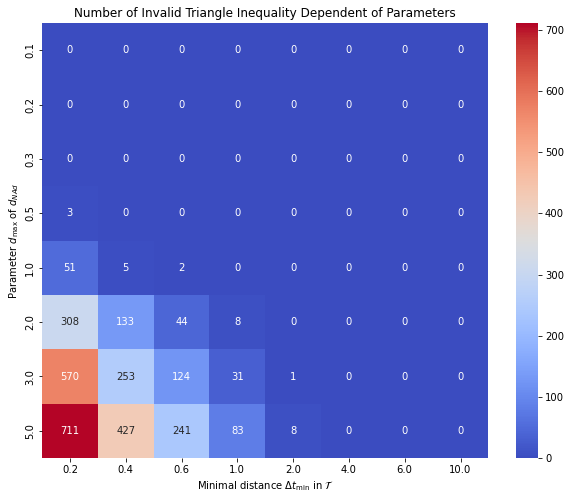

In [14]:
# Plot invalid triangle inequality as heatmap
df_num_false = pd.DataFrame(arr_num_false, index=space_dmax, columns=space_delta_t_min)

# Use seaborn to create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_num_false, annot=True, fmt=".0f", cmap="coolwarm")
plt.title('Number of Invalid Triangle Inequality Dependent of Parameters')
plt.xlabel(r'Minimal distance $\Delta t_{\min}$ in $\mathcal{T}$')
plt.ylabel(r'Parameter $d_{\max}$ of $d_{NAd}$')
plt.show()

### Evaluation for different lengths and independent $\mathcal{X},\mathcal{Y},\mathcal{Z}$

The proof of the triangular inequality requires same sample sizes of $\mathcal{X},\mathcal{Y},\mathcal{Z}$ and their dependency to $\mathcal{T}$. The dependency was only required to limit the term in Lemma 1 based on $\varepsilon + \vert \phi \vert$ and is not required if we rely on the contrained $d_{\max}$.
For unequal sample sizes we can apply a trick with which we fill up missing elements by very high dummy values with $\Delta t_{\min}$ inter-element distance that are shifted between $\mathcal{X},\mathcal{Y},\mathcal{Z}$ such that they can't match with distance $< d_{\max}$.
Each dummy element will be matched with distance $d_{\max}$, thus increasing the $D_{\text{NAd}}$.

In [15]:
# simulate the triangle inequality with random parameters and assert property if the conditions hold
def run_triangle_ineq_difflengths(delta_t_min=1.0, dist_max=1.0, do_assert=True):
    # Define the measurements of the events
    arr_x = np.sort(np.cumsum(np.random.normal(loc=0, scale=0.5, size=np.random.randint(2, 10))**2 + delta_t_min))
    arr_y = np.sort(np.cumsum(np.random.normal(loc=0, scale=0.5, size=np.random.randint(2, 10))**2 + delta_t_min))
    arr_z = np.sort(np.cumsum(np.random.normal(loc=0, scale=0.5, size=np.random.randint(2, 10))**2 + delta_t_min))

    # Trick fill the missing values with dummy entries that are matched with distance dist_max
    # not required in practical applications and could also lead to floating point precision errors
    max_l = max(len(arr_x), len(arr_y), len(arr_z))
    arr_x = np.concatenate((arr_x, np.linspace(1e9, 1e9+(max_l-len(arr_x))*delta_t_min, max_l-len(arr_x))))
    arr_y = np.concatenate((arr_y, np.linspace(2e9, 2e9+(max_l-len(arr_y))*delta_t_min, max_l-len(arr_y))))
    arr_z = np.concatenate((arr_z, np.linspace(3e9, 3e9+(max_l-len(arr_z))*delta_t_min, max_l-len(arr_z))))

    # Apply non-symmetric variant
    min_mean_dist_1 = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
    min_mean_dist_2 = nearest_advocate_single(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
    min_mean_dist_3 = nearest_advocate_single(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

    # # Apply symmetric variant
    # min_mean_dist_1 = nearest_advocate_sym(arr_ref=arr_x, arr_sig=arr_z, dist_max=dist_max)
    # min_mean_dist_2 = nearest_advocate_sym(arr_ref=arr_x, arr_sig=arr_y, dist_max=dist_max)
    # min_mean_dist_3 = nearest_advocate_sym(arr_ref=arr_y, arr_sig=arr_z, dist_max=dist_max)

    # Assert property for both conditions, use small addendum to handle rounding errors
    if do_assert:
        if dist_max <= delta_t_min / 2:
            if not min_mean_dist_1 <= min_mean_dist_2 + min_mean_dist_3 + 1e-12:
                print("\n  Contradiction with small dist_max")

                print(min_mean_dist_1, min_mean_dist_2, min_mean_dist_3, min_mean_dist_2 + min_mean_dist_3)
                print("[" + ", ".join([str(v) for v in arr_x]) + "]")
                print("[" + ", ".join([str(v) for v in arr_y]) + "]")
                print("[" + ", ".join([str(v) for v in arr_z]) + "]")
            assert min_mean_dist_1 <= min_mean_dist_2 + min_mean_dist_3 + 1e-12

    return min_mean_dist_1 <= min_mean_dist_2 + min_mean_dist_3 + 1e-12

run_triangle_ineq_difflengths(delta_t_min=1.0, dist_max=0.5, do_assert=True)

True

In [16]:
# Systematic search for invalid parameters
n_runs = SIM_COUNT
space_dmax =        [0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 5.0]
space_delta_t_min = [0.2, 0.4, 0.6, 1.0, 2.0, 4.0, 6.0, 10.0]
arr_num_false = np.zeros((len(space_dmax), len(space_delta_t_min)))

for i, dist_max in enumerate(space_dmax):
    for j, delta_t_min in enumerate(space_delta_t_min):
        for run in range(n_runs):
            # generate random parameters
            size_n = np.random.randint(5, 50)
            epsilon = delta_t_min / 2 * np.random.random()
            phi = np.random.normal(loc=0, scale=5)
            # Simulate and cumulate
            arr_num_false[i,j] += not run_triangle_ineq_difflengths(
                delta_t_min=delta_t_min, dist_max=dist_max,
                do_assert=True)
int(np.sum(arr_num_false))

1915

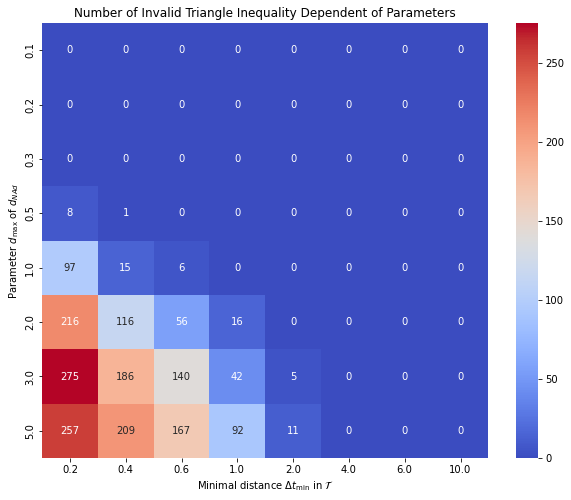

In [17]:
# Plot invalid triangle inequality as heatmap
df_num_false = pd.DataFrame(arr_num_false, index=space_dmax, columns=space_delta_t_min)

# Use seaborn to create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_num_false, annot=True, fmt=".0f", cmap="coolwarm")
plt.title('Number of Invalid Triangle Inequality Dependent of Parameters')
plt.xlabel(r'Minimal distance $\Delta t_{\min}$ in $\mathcal{T}$')
plt.ylabel(r'Parameter $d_{\max}$ of $d_{NAd}$')
plt.show()